In [12]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import multi_tracker_analysis as mta
import pairs2groups
import scipy.stats

import figurefirst
import flystat
import fly_plot_lib.plot as fpl
import fly_plot_lib.text as flytext

In [13]:
def get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[2400,4800],
                                                          speed='high', speed_threshold=2.3):
    paths = mta.read_hdf5_file_to_pandas.get_filenames(directory, contains='day')
    N = []
    for path in paths:
        n = get_number_of_fly_entries_for_flowrate_for_day(path, flowrate, timerange, speed, speed_threshold)
        if n is not None:
            N.append(n)
    N = np.hstack(N)
    return N
    
def get_number_of_fly_entries_for_flowrate_for_day(directory, flowrate, timerange=[2400,4800], 
                                                   speed='high', speed_threshold=2.3):
    filename = mta.read_hdf5_file_to_pandas.get_filename(directory, 'pd_data.pickle')
    pd = pandas.read_pickle(filename)
    pd['pretrial_speed'] = 0.0

    # calculate pretrial speed
    for index, row in pd.iterrows():
        pd.pretrial_speed[index] = np.mean(row.speed[1200:2400])

    if speed == 'high':
        q_pretrial_speed = 'pretrial_speed >= ' + str(speed_threshold)
    else:
        q_pretrial_speed = 'pretrial_speed < ' + str(speed_threshold)
    q = 'flowrate < ' + str(flowrate+0.01) + ' and flowrate > ' + str(flowrate-0.01) + ' and ' + q_pretrial_speed
    pd_odor = pd.query(q)
    
    t_idx = float(timerange[1]-timerange[0]) # timerange in indices
    indices_per_min = 2400/10.
    

    if len(pd_odor) > 0:
        a = np.vstack(pd_odor.n_flies_odor.values)
        da = a[:,1:] - a[:,0:-1] # difference (positive values means flies entered)
        idx = np.where(da<0) # get rid of departures
        da[idx] = np.nan
        N = np.nansum(da[:,timerange[0]:timerange[1]], axis=1) # total number of entries during CO2 presentation
        N_per_time = N/t_idx*indices_per_min
        
        return N_per_time/10. # 10 flies
    else:
        return None

In [14]:
directory = '/media/caveman/CO2_hdf5_uw/CO2_data_notrajecs/low_flow_walking_arena_B_HCS_concentration/hcs_24hrstarved'
N_0 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0)
N_04 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0.4)
N_12 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 1.2)
N_35 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 3.5)

print np.mean(N_0), np.mean(N_04), np.mean(N_12), np.mean(N_35)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.83069869951 2.81311780648 3.48178940511 2.59523392386


In [ ]:
layout = figurefirst.svg_to_axes.FigureLayout('n_approaches.svg') 
layout.make_mplfigures()

ax = layout.axes['n_approaches_stats','n_approaches_stats']

data = [N_0, N_04, N_12, N_35]

for i, d in enumerate(data):
    fpl.scatter_box(ax, i, d, xwidth=0.3, 
                    ywidth=1, color=(0.001, 0.001, 0.001), linewidth=2, edgecolor='none', 
                    shading='95conf', use='mean', hide_markers=True)
    
figurefirst.mpl_functions.adjust_spines(ax, ['left', 'bottom'], xticks=[0,1,2,3], yticks=[1.5,2.0,2.5,3.0,3.5,4.0], 
                                        spine_locations={'bottom': 5, 'bottom': 5}, linewidth=0.5)

ax.set_xticklabels([])
flytext.set_fontsize(ax.figure, 6)

layout.append_figure_to_layer(layout.figures['n_approaches_stats'], 'n_approaches_stats', cleartarget=True)
layout.write_svg('n_approaches.svg')

In [15]:
print scipy.stats.ks_2samp(N_0, N_04)
print scipy.stats.ks_2samp(N_0, N_12)
print scipy.stats.ks_2samp(N_0, N_35)

Ks_2sampResult(statistic=0.57777777777777783, pvalue=0.0092826986315927909)
Ks_2sampResult(statistic=0.82857142857142863, pvalue=3.1796458750868597e-05)
Ks_2sampResult(statistic=0.41428571428571426, pvalue=0.017371595955742763)


In [8]:
def plot_n_approaches_time_series(flowrate, tag):
    directory = '/media/caveman/CO2_hdf5_uw/CO2_data_notrajecs/low_flow_walking_arena_B_HCS_concentration/hcs_24hrstarved'
    
    t1 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[0,1200])
    t2 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[1200,2400])
    t3 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[2400,3600])
    t4 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[3600,4800])
    t5 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[4800,6000])
    t6 = get_number_of_fly_entries_for_flowrate_for_experiment(directory, flowrate, timerange=[6000,7200])

    data = [t1, t2, t3, t4, t5, t6]
    
    layout = figurefirst.svg_to_axes.FigureLayout('n_approaches.svg') 
    layout.make_mplfigures()

    ax = layout.axes[tag, tag]
    
    ax.fill_between([1.5,3.5], 1, 6.0, facecolor='green', edgecolor='none', alpha=0.3)

    for i, d in enumerate(data):
        fpl.scatter_box(ax, i, d, xwidth=0.3, 
                        ywidth=1, color=(0.001, 0.001, 0.001), linewidth=2, edgecolor='none', 
                        shading='95conf', use='mean', hide_markers=True)

    if '00' in tag:
        figurefirst.mpl_functions.adjust_spines(ax, ['left'], yticks=[1,2,3,4,5,6], 
                                                spine_locations={'bottom': 5, 'bottom': 5}, linewidth=0.5)
    else:
        figurefirst.mpl_functions.adjust_spines(ax, [], 
                                                spine_locations={'bottom': 5, 'bottom': 5}, linewidth=0.5)
        
    ax.set_ylim(0.9,6.0)
    ax.set_xlim(-1, 6)
    flytext.set_fontsize(ax.figure, 6)

    layout.append_figure_to_layer(layout.figures[tag], tag, cleartarget=True)
    layout.write_svg('n_approaches.svg')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Removing node: #text
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: defs
Removing node: defs
Removing node: g
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: defs
Removing node: defs
Removing node: g
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: defs
Removing node: defs
Removing node: g
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: #text
Removing node: defs
Removing node: defs
Removing node: g


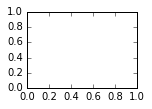

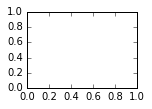

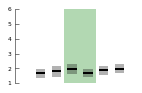

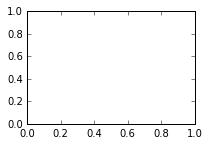

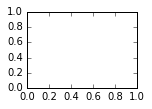

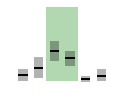

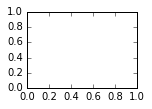

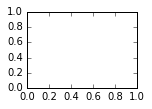

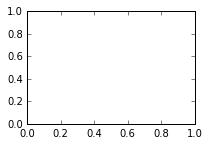

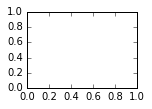

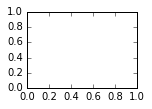

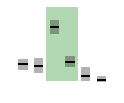

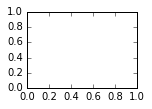

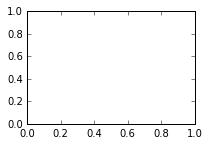

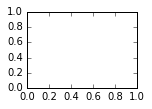

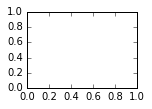

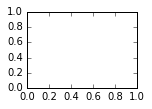

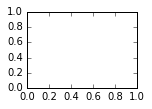

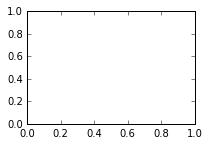

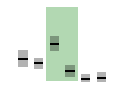

In [9]:
plot_n_approaches_time_series(0, 'n_approaches_00')
plot_n_approaches_time_series(0.4, 'n_approaches_04')
plot_n_approaches_time_series(1.2, 'n_approaches_12')
plot_n_approaches_time_series(3.5, 'n_approaches_35')

In [10]:
directory = '/media/caveman/CO2_hdf5_uw/CO2_data_notrajecs/low_flow_walking_arena_B_HCS_concentration/hcs_24hrstarved'
control_early = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0, timerange=[2400,3600])
control_late = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0, timerange=[3600,4800])

co2_04_early = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0.4, timerange=[2400,3600])
co2_04_late = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 0.4, timerange=[3600,4800])

co2_12_early = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 1.2, timerange=[2400,3600])
co2_12_late = get_number_of_fly_entries_for_flowrate_for_experiment(directory, 1.2, timerange=[3600,4800])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
print scipy.stats.ks_2samp(control_early, co2_04_early)
print scipy.stats.ks_2samp(control_early, co2_12_early)
print scipy.stats.ks_2samp(control_late, co2_04_late)
print scipy.stats.ks_2samp(control_late, co2_12_late)

Ks_2sampResult(statistic=0.5174603174603174, pvalue=0.026879888026364023)
Ks_2sampResult(statistic=0.88571428571428568, pvalue=6.5716174641646502e-06)
Ks_2sampResult(statistic=0.57777777777777783, pvalue=0.0092826986315927909)
Ks_2sampResult(statistic=0.48888888888888887, pvalue=0.04269709376679607)
